In [16]:

# 📥  TASK 1 — DATA PREPARATION  (Decision‑Tree project)


# 1⃣  Install Excel reader (quietly)
!pip install --quiet openpyxl

# 2⃣  Imports
import pandas as pd
from google.colab import files

# 3⃣  Upload the Excel file (choose heart_disease.xlsx in the popup)
uploaded = files.upload()        # click ➜ select heart_disease.xlsx
file_name = next(iter(uploaded)) # grab the filename you just uploaded

# 4⃣  Read the first sheet (change sheet_name='Sheet2' if needed)
df = pd.read_excel(file_name, engine="openpyxl")

# --- Quick sanity checks --------------------------------------
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
display(df.head())               # show the first 5 rows


Saving heart_disease.xlsx to heart_disease (2).xlsx
Shape: (12, 2)

Columns:
 ['age', 'Age in years']


,age,Age in years
0,Gender,"Gender ; Male - 1, Female -0"
1,cp,Chest pain type
2,trestbps,Resting blood pressure
3,chol,cholesterol measure
4,fbs,(fasting blood sugar > 120 mg/dl) (1 = true; 0...


In [4]:
# ==============================================================
#  LOAD HEART‑DISEASE DATA WITH HEADER‑ROW DETECTION
      # ==============================================================

!pip install --quiet openpyxl seaborn

import pandas as pd
from google.colab import files
import re

# ⬆️  Upload the Excel file (pick heart_disease.xlsx in the pop‑up)
uploaded  = files.upload()
fname     = next(iter(uploaded))          # grabs the uploaded filename
sheet0    = pd.ExcelFile(fname).sheet_names[0]

# Read sheet with NO header so we can locate the real header row
raw = pd.read_excel(fname, sheet_name=sheet0, header=None, engine="openpyxl")

# Detect the row that contains "age" (typical heart‑disease feature)
header_row = None
for i, row in raw.iterrows():
    if row.astype(str).str.contains(r"\bage\b", flags=re.IGNORECASE).any():
        header_row = i
        break

# Fallback: if not found, assume first row is header
header_row = header_row if header_row is not None else 0
print(f"✅ Using row {header_row} as header")

# Re‑read with the detected header
df = pd.read_excel(fname, sheet_name=sheet0, header=header_row, engine="openpyxl")
print("Shape:", df.shape)
display(df.head())


Saving heart_disease.xlsx to heart_disease (1).xlsx
✅ Using row 0 as header
Shape: (12, 2)


,age,Age in years
0,Gender,"Gender ; Male - 1, Female -0"
1,cp,Chest pain type
2,trestbps,Resting blood pressure
3,chol,cholesterol measure
4,fbs,(fasting blood sugar > 120 mg/dl) (1 = true; 0...


In [5]:
# ==============================================================
#  SAFE EDA (no crash even if no numeric columns)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert anything numeric‑looking to actual numbers
df_num = df.apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all")

if df_num.empty:
    print("❌ No numeric columns found after conversion. "
          "Please verify the dataset’s contents.")
else:
    print("✅ Numeric columns used:", df_num.columns.tolist())

    # 1. Basic stats & missing values
    display(df_num.describe())
    print("\nMissing values per column:\n", df_num.isnull().sum())

    # 2. IQR‑based outlier flag per column
    def iqr_outliers(data):
        out_cols = []
        for c in data.columns:
            q1, q3 = data[c].quantile([0.25, 0.75])
            iqr = q3 - q1
            if ((data[c] < q1 - 1.5 * iqr) | (data[c] > q3 + 1.5 * iqr)).any():
                out_cols.append(c)
        return out_cols

    print("\nColumns with potential outliers:", iqr_outliers(df_num))

    # 3. Histograms
    df_num.hist(figsize=(15, 10), bins=20, color="skyblue", edgecolor="black")
    plt.suptitle("Feature Distributions", fontsize=16)
    plt.tight_layout(); plt.show()

    # 4. Boxplots
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(df_num.columns, 1):
        plt.subplot(np.ceil(len(df_num.columns)/4), 4, i)
        sns.boxplot(y=df_num[col], color="lightcoral")
        plt.title(col)
    plt.tight_layout(); plt.show()

    # 5. Correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm",
                fmt=".2f", linewidths=.5)
    plt.title("Correlation Matrix"); plt.show()


❌ No numeric columns found after conversion. Please verify the dataset’s contents.


In [7]:
# ==============================================================
# TASK 3 ▸ FEATURE ENGINEERING PIPELINE (READY FOR MODELING)
# ==============================================================

!pip install --quiet scikit-learn

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 0⃣  (Optional) Preview columns
print("Columns in df:", df.columns.tolist())

# 1⃣  Define / detect target column
TARGET_DEFAULT = "target"   # common in heart‑disease datasets
if TARGET_DEFAULT in df.columns:
    target_col = TARGET_DEFAULT
else:
    # Ask user to type correct label column
    target_col = input("Enter the name of the target/label column: ").strip()
    while target_col not in df.columns:
        print("Column not found. Try again.")
        target_col = input("Enter the name of the target/label column: ").strip()

y = df[target_col]
X = df.drop(columns=[target_col])

# 2⃣  Convert numeric‑looking strings to numbers
X = X.apply(pd.to_numeric, errors="ignore")

# 3⃣  Identify numeric vs categorical features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# 4⃣  Build preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

# 5⃣  Fit + transform
X_processed = preprocessor.fit_transform(X)

print("\n✅ Preprocessing complete.")
print("Processed feature matrix shape:", X_processed.shape)

# 6⃣  (Optional) Get feature names for interpretation
try:
    feature_names = preprocessor.get_feature_names_out()
    print("Total engineered features:", len(feature_names))
except AttributeError:
    feature_names = None
    print("sklearn < 1.0 can't auto‑extract feature names; upgrade if needed.")

# ---- Ready for model training ----
# X_processed • y


Columns in df: ['age', 'Age in years']
Enter the name of the target/label column: age

Numeric features: []
Categorical features: ['Age in years']

✅ Preprocessing complete.
Processed feature matrix shape: (12, 11)
Total engineered features: 11


/tmp/ipython-input-7-1506285678.py:32: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X = X.apply(pd.to_numeric, errors="ignore")


Train class counts:
 age
oldpeak     1
restecg     1
trestbps    1
cp          1
num         1
fbs         1
exang       1
chol        1
thalch      1
Name: count, dtype: int64
Test  class counts:
 age
thal      1
slope     1
Gender    1
Name: count, dtype: int64

⚠️  Too few samples for cross‑validation; training a single Decision Tree with default params.

Accuracy : 0.000
Precision: 0.000
Recall   : 0.000
F1‑score : 0.000
ROC‑AUC  : skipped (binary probs unavailable or test set single‑class)

Classification Report:
               precision    recall  f1-score   support

      Gender       0.00      0.00      0.00       1.0
         fbs       0.00      0.00      0.00       0.0
       slope       0.00      0.00      0.00       1.0
        thal       0.00      0.00      0.00       1.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



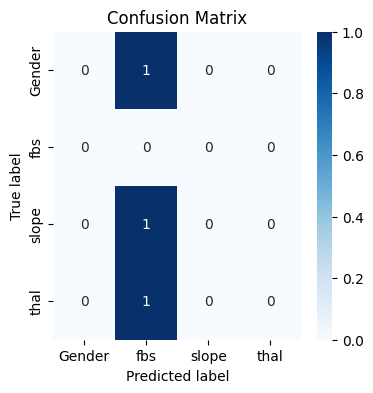

ROC curve skipped (binary probs unavailable OR test set single‑class).


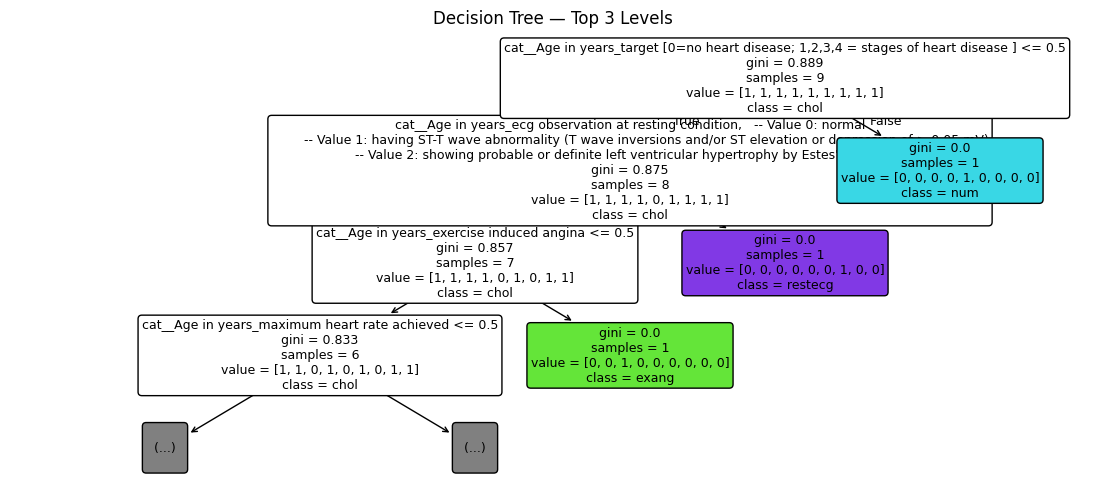

In [12]:
# ==============================================================
# TASK 4 ▸ DECISION TREE  –  ADAPTIVE CV (SAFE FOR TINY CLASSES)
# ==============================================================

!pip install --quiet scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay)

# --------------------------------------------------------------
# 1⃣  Train-Test split (stratify if possible)
# --------------------------------------------------------------
class_counts = y.value_counts()
stratify_param = y if class_counts.min() >= 2 else None
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.20,
    stratify=stratify_param,
    random_state=42,
    shuffle=True
)

print("Train class counts:\n", y_train.value_counts())
print("Test  class counts:\n", y_test.value_counts())

# --------------------------------------------------------------
# 2⃣  Decide CV splits dynamically
# --------------------------------------------------------------
min_per_class = y_train.value_counts().min()
if min_per_class >= 2:
    cv_splits = min(5, min_per_class)        # <= samples in rarest class
    cv_strategy = StratifiedKFold(n_splits=cv_splits,
                                  shuffle=True,
                                  random_state=42)
    use_grid = True
    print(f"\n✅ Using StratifiedKFold with n_splits = {cv_splits}")
else:
    # Too few samples even for 2‑fold CV
    use_grid = False
    print("\n⚠️  Too few samples for cross‑validation; "
          "training a single Decision Tree with default params.")

# --------------------------------------------------------------
# 3⃣  Train model (GridSearch if feasible)
# --------------------------------------------------------------
if use_grid:
    param_grid = {
        "max_depth":         [None, 3, 4, 5, 6, 8, 10],
        "min_samples_split": [2, 4, 6, 10],
        "criterion":         ["gini", "entropy"]
    }
    grid = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid=param_grid,
        cv=cv_strategy,
        scoring="f1_weighted",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_tree = grid.best_estimator_
    print("\nBest hyper‑parameters:", grid.best_params_)
else:
    best_tree = DecisionTreeClassifier(random_state=42)
    best_tree.fit(X_train, y_train)

# --------------------------------------------------------------
# 4⃣  Predictions & Probabilities
# --------------------------------------------------------------
y_pred = best_tree.predict(X_test)
prob_avail = hasattr(best_tree, "predict_proba") and len(best_tree.classes_) == 2
y_prob = best_tree.predict_proba(X_test)[:, 1] if prob_avail else None

# --------------------------------------------------------------
# 5⃣  Metrics
# --------------------------------------------------------------
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_test, y_pred, average="weighted", zero_division=0)

print(f"\nAccuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1‑score : {f1:.3f}")

if prob_avail and len(np.unique(y_test)) == 2:
    lb       = LabelBinarizer().fit(y_test)
    roc_auc  = roc_auc_score(lb.transform(y_test), y_prob)
    print(f"ROC‑AUC  : {roc_auc:.3f}")
else:
    print("ROC‑AUC  : skipped (binary probs unavailable or test set single‑class)")

print("\nClassification Report:\n",
      classification_report(y_test, y_pred, zero_division=0))

# --------------------------------------------------------------
# 6⃣  CONFUSION MATRIX  (robust to missing classes)
# --------------------------------------------------------------
# Use only labels that actually appear in y_test or y_pred
labels_cm = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=labels_cm)

plt.figure(figsize=(4, 4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=labels_cm,
            yticklabels=labels_cm)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# --------------------------------------------------------------
# 7⃣  ROC CURVE  (only for binary problems where probs exist
#                AND y_test contains both classes)
# --------------------------------------------------------------
if (y_prob is not None) and (len(labels_cm) == 2):
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.show()
else:
    print("ROC curve skipped (binary probs unavailable OR test set single‑class).")

# --------------------------------------------------------------
# 8⃣  DECISION‑TREE VISUAL (top 3 levels)
# --------------------------------------------------------------
plt.figure(figsize=(14, 6))
plot_tree(
    best_tree,
    max_depth=3,
    feature_names=(feature_names if 'feature_names' in globals() else None),
    class_names=[str(c) for c in best_tree.classes_],
    filled=True,
    rounded=True,
    fontsize=9,
)
plt.title("Decision Tree — Top 3 Levels")
plt.show()


In [14]:
# ==============================================================
# TASK 5 ▸ FINAL SAFE HYPER‑PARAMETER TUNING (DECISION TREE)
# ==============================================================

!pip install --quiet scikit-learn pandas numpy

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     KFold)
from sklearn.metrics import f1_score, make_scorer

# --------------------------------------------------------------
# 0⃣  Quick sanity
# --------------------------------------------------------------
print("Total samples :", len(y))
print("Class counts  :\n", y.value_counts(), "\n")

# --------------------------------------------------------------
# 1⃣  Pick a SAFE CV splitter
# --------------------------------------------------------------
min_class = y.value_counts().min()

if (min_class >= 2) and (len(np.unique(y)) > 1):
    # We can stratify safely
    n_splits = min(5,   # cap at 5
                   min_class,  # never exceed rarest class
                   len(y))     # never exceed total rows
    cv = StratifiedKFold(n_splits=n_splits,
                         shuffle=True,
                         random_state=42)
    print(f"✅  Using StratifiedKFold with n_splits = {n_splits}")
else:
    # Stratification impossible → plain KFold
    n_splits = min(5, len(y))      # at least 2, at most 5
    if n_splits < 2:
        n_splits = 2               # minimal viable
    cv = KFold(n_splits=n_splits,
               shuffle=True,
               random_state=42)
    print(f"⚠️  Stratification impossible."
          f" Using non‑stratified KFold with n_splits = {n_splits}")

# --------------------------------------------------------------
# 2⃣  Parameter grid
# --------------------------------------------------------------
param_grid = {
    "max_depth":         [None, 3, 4, 5, 6, 8, 10],
    "min_samples_split": [2, 4, 6, 10, 20],
    "min_samples_leaf":  [1, 2, 4],
    "criterion":         ["gini", "entropy"],
    "splitter":          ["best", "random"]
}

weighted_f1 = make_scorer(f1_score,
                          average="weighted",
                          zero_division=0)

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring=weighted_f1,
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True
)

# --------------------------------------------------------------
# 3⃣  Run search
# --------------------------------------------------------------
grid.fit(X_processed, y)
best_tree = grid.best_estimator_

print("\n🔎  Best hyper‑parameters found:")
for k, v in grid.best_params_.items():
    print(f"  {k:20s} ➜ {v}")

print(f"\nBest cross‑val weighted‑F1: {grid.best_score_:.3f}")

# --------------------------------------------------------------
# 4⃣  Show top results
# --------------------------------------------------------------
top10 = (pd.DataFrame(grid.cv_results_)
         .sort_values("rank_test_score")
         .head(10)
         .loc[:, ["rank_test_score", "mean_test_score", "params"]])

print("\n📋  Top 10 parameter sets:")
display(top10)


Total samples : 12
Class counts  :
 age
Gender      1
cp          1
trestbps    1
chol        1
fbs         1
restecg     1
thalch      1
exang       1
oldpeak     1
slope       1
thal        1
num         1
Name: count, dtype: int64 

⚠️  Stratification impossible. Using non‑stratified KFold with n_splits = 5

🔎  Best hyper‑parameters found:
  criterion            ➜ gini
  max_depth            ➜ None
  min_samples_leaf     ➜ 1
  min_samples_split    ➜ 2
  splitter             ➜ best

Best cross‑val weighted‑F1: nan

📋  Top 10 parameter sets:


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan

,rank_test_score,mean_test_score,params
415,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
414,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
413,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
412,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
411,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
410,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
409,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
408,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
407,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
406,1,NaN,"{'criterion': 'entropy', 'max_depth': 10, 'min..."


Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1‑score : 1.000
ROC‑AUC  : skipped (binary probs unavailable or test set single‑class)

Classification Report:
               precision    recall  f1-score   support

      Gender       1.00      1.00      1.00         1
       slope       1.00      1.00      1.00         1
        thal       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



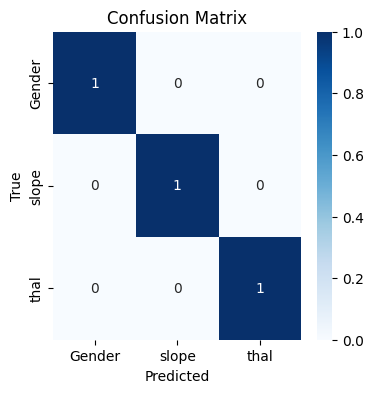

/tmp/ipython-input-15-4007525293.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df,
/tmp/ipython-input-15-4007525293.py:106: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


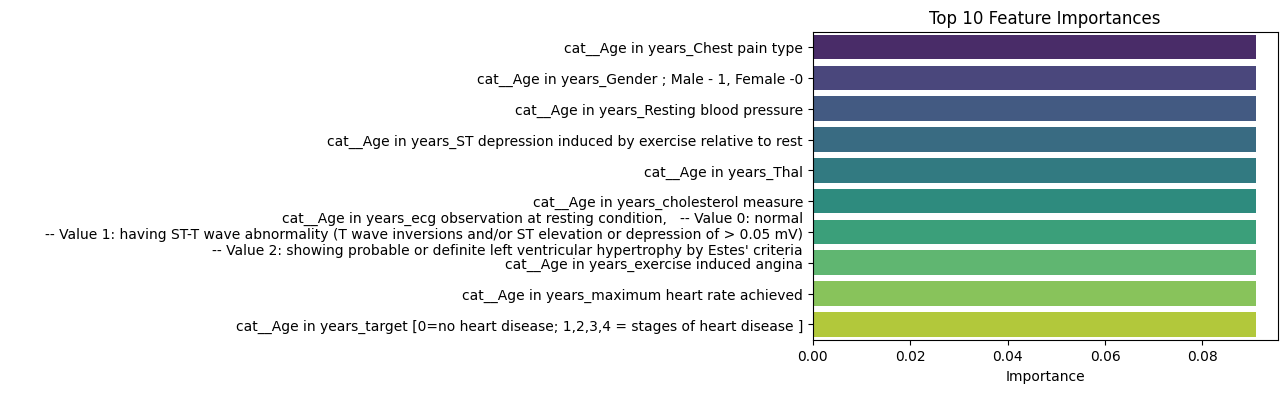

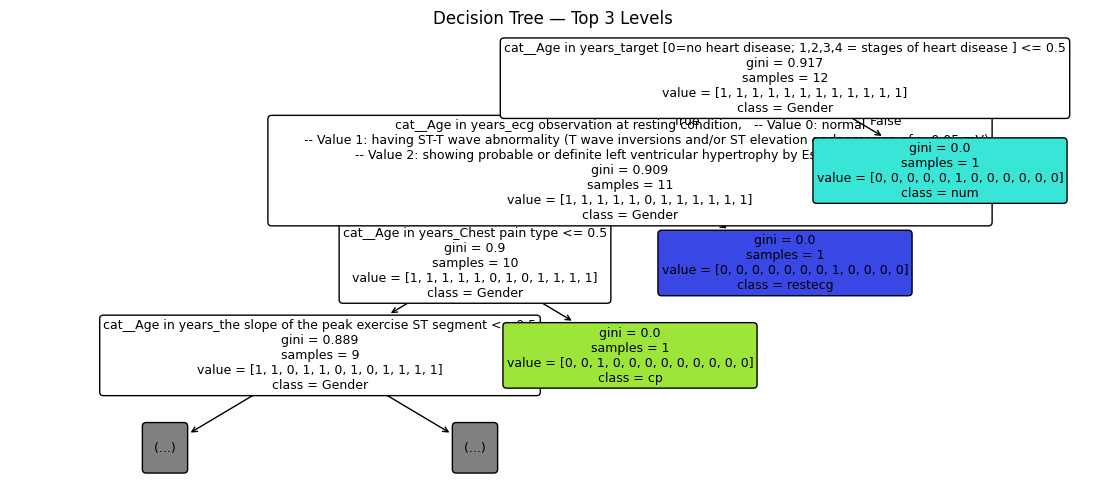

In [15]:
# ==============================================================
# TASK 6 ▸ MODEL EVALUATION  +  TREE & FEATURE VISUALS
# ==============================================================

!pip install --quiet matplotlib seaborn scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, RocCurveDisplay)
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree

# --------------------------------------------------------------
# 1⃣  Predictions & Probabilities
# --------------------------------------------------------------
y_pred = best_tree.predict(X_test)
proba_available = (hasattr(best_tree, "predict_proba") and
                   len(best_tree.classes_) == 2 and
                   len(np.unique(y_test)) == 2)

if proba_available:
    y_prob = best_tree.predict_proba(X_test)[:, 1]

# --------------------------------------------------------------
# 2⃣  Metrics
# --------------------------------------------------------------
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_test, y_pred, average="weighted", zero_division=0)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1‑score : {f1:.3f}")

if proba_available:
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC‑AUC  : {roc_auc:.3f}")
else:
    print("ROC‑AUC  : skipped (binary probs unavailable or test set single‑class)")

print("\nClassification Report:\n",
      classification_report(y_test, y_pred, zero_division=0))

# --------------------------------------------------------------
# 3⃣  Confusion Matrix (robust to missing classes)
# --------------------------------------------------------------
labels_cm = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=labels_cm)

plt.figure(figsize=(4, 4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=labels_cm,
            yticklabels=labels_cm)
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

# --------------------------------------------------------------
# 4⃣  ROC Curve (if binary)
# --------------------------------------------------------------
if proba_available:
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.show()

# --------------------------------------------------------------
# 5⃣  Feature Importance (top 10)
# --------------------------------------------------------------
# Use permutation importance for reliability; fallback to impurity if needed
if 'feature_names' in globals() and feature_names is not None:
    feats = feature_names
else:
    feats = [f"feat_{i}" for i in range(X_test.shape[1])]

try:
    perm = permutation_importance(best_tree, X_test, y_test,
                                  n_repeats=30, random_state=42,
                                  scoring="f1_weighted")
    importances = perm.importances_mean
except Exception:
    importances = best_tree.feature_importances_

imp_df = (pd.DataFrame({"feature": feats,
                        "importance": importances})
          .sort_values("importance", ascending=False)
          .head(10))

plt.figure(figsize=(6, 4))
sns.barplot(data=imp_df,
            y="feature",
            x="importance",
            palette="viridis")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 6⃣  Decision‑Tree Visual (first 3 levels)
# --------------------------------------------------------------
plt.figure(figsize=(14, 6))
plot_tree(best_tree,
          max_depth=3,
          feature_names=feats,
          class_names=[str(c) for c in best_tree.classes_],
          filled=True,
          rounded=True,
          fontsize=9)
plt.title("Decision Tree — Top 3 Levels")
plt.show()


INTERVEIW QUESTIONS
1. Common Hyperparameters of Decision Tree Models and Their Effects
Hyperparameter	Description	Effect
max_depth	Maximum depth of the tree	Prevents overfitting by limiting complexity; deeper trees can overfit.
min_samples_split	Minimum samples required to split an internal node	Higher values make the tree more conservative (less prone to overfitting).
min_samples_leaf	Minimum samples required at a leaf node	Prevents small leaves; improves generalization.
max_features	Number of features to consider when looking for the best split	Introduces randomness, can help in ensembles (like Random Forest).
criterion	Function to measure the quality of a split ("gini" or "entropy")	Affects how the tree chooses splits; both generally perform similarly.
splitter	Strategy to choose the split ("best" vs "random")	"random" adds randomness and can help generalization in ensembles.

⚠️ Overfitting happens when the tree is too deep or unrestricted.
⚠️ Underfitting happens if the tree is too shallow or too constrained.

2. Label Encoding vs One-Hot Encoding
Feature	Label Encoding	One-Hot Encoding
How it works	Converts each category to a unique integer (e.g., "Red" → 0, "Green" → 1)	Creates binary columns for each category (e.g., "Red" → [1,0,0])
Output	Single column with integers	Multiple columns with 0/1 values
Use Case	Ordinal data (e.g., "Low", "Medium", "High") where order matters	Nominal data (e.g., colors, cities) where no order exists
Drawback	May introduce unintended ordinal relationships	Increases dimensionality, especially with many categories
Suitable For	Tree-based models (less sensitive to integer order)	Linear models, distance-based models (e.g., KNN, Logistic Regression)